In [ ]:
### RUN f0dl_bernox.py ###

import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

# json_regex = '/om2/user/msaddler/pitchnet/saved_models/*classification1/EVAL_bernox2005_MovingFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/*/EVAL_bernox2005_MovingFilter_f0min080_f0max640_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification1/EVAL_bernox2005_*_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/bernox2005like_SyntheticBandpassJWSS_model0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/test_regression/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/bernox2005like_SyntheticBandpassJWSS_model0_sigmoid_regression/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/test_ibm*/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_l2regression0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_l1regression0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification1/EVAL_bernox2005_LowSpec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch001seed*_PND_v00_JWSS_classification/EVAL_bernox2005_*Spec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v01_JWSS_highSNR_*/EVAL_bernox2005_*Spec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/*classification1/EVAL_bernox2005_LowSpec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification1/EVAL_bernox2005_HighSpec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v01_JWSS_halfbandpass_classification1/EVAL_bernox2005_MovingFilter_f0min080_f0max640_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification1/EVAL_bernox2005_*_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification*/EVAL_bernox2005_MovingFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classificationl2regression*/EVAL_bernox2005_*_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v0[0|3]_JWSS_classification[0-2]/EVAL_bernox2005_MovingFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v03_JWSS_classification*/EVAL_bernox2005_MovingFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS*_classification*/EVAL_bernox2005_FixedFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS*_classification*/EVAL_bernox2005_FixedFilter_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v0[3|5|6]_JWSS_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt.json'
# json_regex = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v00/arch_0211/EVAL_bernox2005_FixedFilter_bestckpt.json'
# json_regex = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v00/arch_0099/EVAL_bernox2005_FixedFilter_bestckpt.json'
# json_regex = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v00/arch_0703/EVAL_bernox2005_FixedFilter_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt*.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_halfbandpass*_classification*/EVAL_bernox2005_FixedFilter_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/*PND_v04_JWS*[Ss]_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_[ch]*lassification*/EVAL_bernox2005_FixedFilter_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_[ch]*lassification*/EVAL_bernox2005_FixedFilter_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name[:model_name.rfind('/')]
#     model_name = os.path.basename(json_fn)
    model_name_list.append(model_name)
print('found {} files'.format(len(json_fn_list)))

# model_name_list = ['Train (G&M bandwidths) + Test (G&M bandwidths)']*3 + ['Train (2x broader) + Test (2x broader)']*3 + ['Train (3x broader) + Test (3x broader)']*3
# model_name_list = ['Train (G&M bandwidths) + Test (G&M bandwidths)', 'Train (G&M bandwidths) + Test (2x broader)', 'Train (G&M bandwidths) + Test (3x broader)']
# model_name_list = model_name_list + model_name_list + model_name_list

results_dict_list = []
confmat_dict_list = []
for fn, mn in zip(json_fn_list, model_name_list):
    print(fn)
    
    fn_results_dict = fn.replace('.json', '_results_dict.json')
    if os.path.exists(fn_results_dict):
        print('loading pre-computed file')
        with open(fn_results_dict) as f:
            results_dict = json.load(f)
    else:
    
    #     if 'log2' in mn:
    #         f0_label_pred_key='f0_log2:labels_pred'
    #         f0_label_true_key='f0_log2:labels_true'
        if True:#'classification' in mn:
            f0_label_pred_key='f0_label:labels_pred'
            f0_label_true_key='f0_label:labels_true'
        else:
            f0_label_pred_key = 'f0_lognormal:labels_pred'
            f0_label_true_key = 'f0_lognormal:labels_true'

        metadata_key_list=['low_harm', 'phase_mode', 'f0']
        if 'FixedFilter' in fn: metadata_key_list = metadata_key_list + ['base_f0']
        results_dict = f0dl_bernox.run_f0dl_experiment(fn, max_pct_diff=3, bin_width=5e-2,
                                                       f0_label_pred_key=f0_label_pred_key,
                                                       f0_label_true_key=f0_label_true_key,
                                                       use_empirical_f0dl_if_possible=False,
                                                       metadata_key_list=metadata_key_list,
                                                       f0_min=-np.inf, f0_max=np.inf)
        confmat_dict = f0dl_bernox.compute_confusion_matrices(json_fn,
                                                              f0_label_pred_key=f0_label_pred_key,
                                                              f0_label_true_key=f0_label_true_key)
        confmat_dict_list.append(confmat_dict)

    results_dict_list.append(results_dict)
    
human_results_dict = f0dl_bernox.bernox2005_human_results_dict()


In [ ]:
### PLOT THRESHOLDS f0dl_bernox.py ###

def make_threshold_plot(ax, results_dict, title_str=None, legend_on=True,
                        sine_plot_kwargs={}, rand_plot_kwargs={}):
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xlabel('Lowest harmonic number', fontsize=10)
    ax.set_ylabel('F0 discrimination threshold (%F0)', fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=8)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=10)


NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = ax_arr.T
ax_arr = ax_arr.flatten()

for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
    ax = ax_arr[idx]
    title_str=model_name
    make_threshold_plot(ax, human_results_dict, title_str=None, legend_on=False,
                        sine_plot_kwargs={'color':'r', 'lw':0.5}, rand_plot_kwargs={'color':'r', 'lw':0.5})
    make_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True,
                        sine_plot_kwargs={'color':'k', 'lw':2}, rand_plot_kwargs={'color':'b', 'lw':2})
    ax.grid(color=[0.8, 0.8, 0.8], linestyle='-', linewidth=0.5)

for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_09_11_archSearch00_humanComparison/2019SEP11_RSB_PNDv04_bernox2005_FixedFilter_f0_thresholds_varyingDropoutParams.pdf', bbox_inches='tight')



In [ ]:
for key in results_dict.keys():
    print(key, type(results_dict[key]), type(results_dict[key][0]))

In [ ]:
### PLOT PSYCHOMETRIC FUNCTIONS f0dl_bernox.py ###

IDX = -1
results_dict = results_dict_list[IDX]
model_name = model_name_list[IDX]

phase_mode_list = np.array(results_dict['phase_mode'])
low_harm_list = np.array(results_dict['low_harm'])
unique_phase_mode_list = np.unique(phase_mode_list)
unique_low_harm_list = np.unique(low_harm_list)

NCOLS = 4
NROWS = int(np.ceil(len(unique_low_harm_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(5*NCOLS, 2.5*NROWS))
ax_arr = ax_arr.flatten()
for idx, low_harm in enumerate(unique_low_harm_list):
    ax = ax_arr[idx]
    
    for phase_mode in unique_phase_mode_list:
        
        rdi = np.squeeze(np.argwhere(np.logical_and(phase_mode_list==phase_mode, low_harm_list==low_harm)))
        x = results_dict['psychometric_function'][rdi]['bins']
        y = results_dict['psychometric_function'][rdi]['bin_means']
        
        normcdf = lambda x, sigma: scipy.stats.norm(results_dict['psychometric_function'][rdi]['mu'], sigma).cdf(x)
        
        if phase_mode == 0:
            color = 'k'
            label = 'sine'
            ls = '-'
        else:
            color = 'b'
            label = 'rand'
            ls = '-'
        
        ax.plot(x, y, color=color, ls=ls, label=label)
        ax.plot(x, normcdf(x, results_dict['psychometric_function'][rdi]['sigma']), color=color, ls='--')
    
    ax.plot(x, np.ones_like(x)*results_dict['psychometric_function'][rdi]['threshold_value'], 'r--')
    ax.set_ylim([0, 1])
    ax.set_xlim([np.min(x), np.max(x)])
    ax.set_xlabel('%F0 difference')
    ax.set_ylabel('Proportion correct')
    
    ax.legend(loc='lower right', frameon=False, handlelength=0.5)
    ax.text(np.min(x), 1-.05, '  Low harm = {}'.format(low_harm), horizontalalignment='left', verticalalignment='top')

for idx in range(len(unique_low_harm_list), len(ax_arr)): ax_arr[idx].axis('off')
    
plt.tight_layout()
plt.show()

# fig.savefig('bernox2005_MovingFilterHighF0sOnly_psychometric_functions_2019AUG01_{}.pdf'.format(model_name), bbox_inches='tight')


In [ ]:
### PLOT CONFUSION MATRICES f0dl_bernox.py ###

def make_confusion_matrix_plot(ax, confmat_dict, confmat_idx, fontsize=8,
                               title_str=None, log_scale=True,
                               sine_plot_kwargs={}, rand_plot_kwargs={}):
    
    f0_true = confmat_dict['f0_true'][confmat_idx]
    f0_pred = confmat_dict['f0_pred'][confmat_idx]
    
    if confmat_dict['phase_mode'][confmat_idx] == 0:
        plot_kwargs = {'color': 'k', 'ls':'', 'ms':2, 'marker':'.'}
        plot_kwargs.update(sine_plot_kwargs)
    else:
        plot_kwargs = {'color': 'b', 'ls':'', 'ms':2, 'marker':'.'}
        plot_kwargs.update(rand_plot_kwargs)
    
    if title_str is None:
        title_str = 'low_harm={}, phase_mode={}'.format(confmat_dict['low_harm'][confmat_idx],
                                                        confmat_dict['phase_mode'][confmat_idx])
    
    ax.plot(f0_true, f0_pred, **plot_kwargs)
    ax.set_xlim(confmat_dict['f0_min'], confmat_dict['f0_max'])
    ax.set_ylim(confmat_dict['f0_min'], confmat_dict['f0_max'])
    ax.set_xlabel('f0_true', fontsize=fontsize)
    ax.set_ylabel('f0_pred', fontsize=fontsize)
    ax.set_title(title_str, fontsize=fontsize)
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')


IDX = -1
cfmd = confmat_dict_list[IDX]
model_name = model_name_list[IDX]

print(model_name)

phase_mode_list = np.array(confmat_dict['phase_mode'])
low_harm_list = np.array(confmat_dict['low_harm'])
unique_phase_mode_list = np.unique(phase_mode_list)
unique_low_harm_list = np.unique(low_harm_list)

NAXES = len(unique_low_harm_list) * len(unique_phase_mode_list)
NCOLS = 8
NROWS = int(np.ceil(NAXES / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(2.5*NCOLS, 2.5*NROWS))
ax_arr = ax_arr.flatten()
ax_idx = 0
for low_harm in unique_low_harm_list:
    for phase_mode in unique_phase_mode_list:
        ax = ax_arr[ax_idx]
        ax_idx = ax_idx + 1
        rdi = np.squeeze(np.argwhere(np.logical_and(phase_mode_list==phase_mode, low_harm_list==low_harm)))
        make_confusion_matrix_plot(ax, cfmd, rdi)
        
for idx in range(NAXES, len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('bernox2005_MovingFilterHighF0sOnly_confusion_matrices_2019AUG01_{}.pdf'.format(model_name), bbox_inches='tight')


In [ ]:
import sys
import os
import json
import numpy as np
import glob

from f0dl_bernox import *

%matplotlib inline
import matplotlib.pyplot as plt

# json_regex = '/om2/user/msaddler/pitchnet/saved_models/bernox2005like_SyntheticBandpassJWSS_model0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/test_regression/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/bernox2005like_SyntheticBandpassJWSS_model0_sigmoid_regression/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/test_ibm*/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_l2regression0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_l1regression0/EVAL_bernox2005_LowSpec.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification1/EVAL_bernox2005_LowSpec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch001seed*_PND_v00_JWSS_classification/EVAL_bernox2005_*Spec_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v01_JWSS_highSNR_*/EVAL_bernox2005_*Spec_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v01_JWSS_halfbandpass_classification1/EVAL_bernox2005_LowSpec_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name[:model_name.rfind('/')]
    model_name_list.append(model_name)

results_dict_list = []
for json_fn in json_fn_list:
    print(json_fn)
    if 'regress' in json_fn:
        f0_label_pred_key = 'f0_lognormal:labels_pred'
        f0_label_true_key = 'f0_lognormal:labels_true'
    else:
        f0_label_pred_key = 'f0_label:labels_pred'
        f0_label_true_key = 'f0_label:labels_true'
    expt_dict = load_f0_expt_dict_from_json(json_fn,
                                            f0_label_true_key=f0_label_true_key,
                                            f0_label_pred_key=f0_label_pred_key)
    expt_dict = add_f0_estimates_to_expt_dict(expt_dict,
                                              f0_label_true_key=f0_label_true_key,
                                              f0_label_pred_key=f0_label_pred_key)
    
    sine_expt_dict = filter_expt_dict(expt_dict, filter_dict={'phase_mode':0})
    rand_expt_dict = filter_expt_dict(expt_dict, filter_dict={'phase_mode':1})

    sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=6)
    rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=6)
    
    sine_expt_dict = compute_f0_thresholds_for_each_low_harm(sine_expt_dict, bin_width=2e-2)
    rand_expt_dict = compute_f0_thresholds_for_each_low_harm(rand_expt_dict, bin_width=2e-2)
    
    results_dict = {
        'phase_list': [0, 1],
        'lharm_list': sine_expt_dict['low_harm'],
        'sine_f0dl_list': sine_expt_dict['f0dl'],
        'rand_f0dl_list': rand_expt_dict['f0dl'],
        'sine_expt_dict': dict(sine_expt_dict),
        'rand_expt_dict': dict(rand_expt_dict),
    }
    results_dict_list.append(results_dict)


In [ ]:
IDX = -1
results_dict = results_dict_list[IDX]
model_name = model_name_list[IDX]

### MAKE PSYCHOMETRIC FUNCTIONS
lharm_list = results_dict['lharm_list']
NCOLS = 3
NROWS = int(np.ceil(len(lharm_list) / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3*NCOLS, 3*NROWS))
ax = ax.flatten()
for idx in range(len(lharm_list)):
    
    for key in ['sine_expt_dict', 'rand_expt_dict']:
        x = results_dict[key]['psychometric_functions']['bins'][idx]
        y = results_dict[key]['psychometric_functions']['bin_means'][idx]
        normcdf = lambda x, sigma: scipy.stats.norm(results_dict[key]['psychometric_functions']['mu'], sigma).cdf(x)
        
        if 'sine' in key:
            color = 'k'
            label = 'sine'
        else:
            color = 'b'
            label = 'rand'
        
        ax[idx].plot(x, y, color=color, ls='-', label=label)
        ax[idx].plot(x, normcdf(x, results_dict[key]['psychometric_functions']['sigma'][idx]),
                     color=color, ls='--')
    
    ax[idx].plot(x, np.ones_like(x)*results_dict[key]['psychometric_functions']['threshold_value'], 'r--')
    ax[idx].set_ylim([0, 1])
    ax[idx].set_xlim([np.min(x), np.max(x)])
    ax[idx].set_xlabel('%F0 difference')
    ax[idx].set_ylabel('Proportion correct')
    
    ax[idx].legend(loc='lower right', frameon=False, handlelength=0.5)
    
    ax[idx].text(np.min(x), 1-.05, '  Low harm = {}'.format(int(lharm_list[idx])),
                 horizontalalignment='left', 
                 verticalalignment='top')

for idx in range(len(lharm_list), len(ax)): ax[idx].axis('off')
    
plt.tight_layout()
plt.show()

# fig.savefig('psychometric_functions_2019JUL21_bernox2005_LowSpec_maxPctDiffInf_{}.pdf'.format(model_name), bbox_inches='tight')

In [ ]:
# model_name_list = []
# for json_fn in json_fn_list:
#     model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
#     model_name = model_name[:model_name.rfind('/')]
#     model_name_list.append(model_name)

NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
    ax = ax_arr[idx]
    for key in ['rand_expt_dict', 'sine_expt_dict']:
        x = results_dict[key]['low_harm']
        y = results_dict[key]['f0dl']
        if 'sine' in key:
            color = 'k'
            label = 'sine'
        else:
            color = 'b'
            label = 'rand'
        ax.plot(x, y, color=color, marker='.', ls='-', lw=2, markersize=8, label=label)

    ax.set_yscale('log')
    ax.set_ylim([3e-1, 3e2])
    ax.set_xlim([0, 40])
    ax.set_xlabel('Lowest harmonic number')
    ax.set_ylabel('F0 discrimination threshold (%F0)')
    ax.set_title(model_name)
    ax.legend(loc='lower right', frameon=False)

for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('summary_2019JUL21_bernox2005_HighSpec_maxPctDiff12.pdf', bbox_inches='tight')

In [ ]:
results_dict = results_dict_list[0]

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 30])
plt.xlim([0, 40])
plt.legend()
plt.show()

for key in sine_results_dict['psychometric_functions'].keys():
    print(key, type(sine_results_dict['psychometric_functions'][key]))

normcdf = lambda x, sigma: scipy.stats.norm(sine_results_dict['psychometric_functions']['mu'], sigma).cdf(x)

for idx in range(len(sine_results_dict['low_harm'])):
    plt.figure()
    x = sine_results_dict['psychometric_functions']['bins'][idx]
    y = sine_results_dict['psychometric_functions']['bin_means'][idx]
    plt.plot(x, y, 'b-')
    plt.plot(x, normcdf(x, sine_results_dict['psychometric_functions']['sigma'][idx]), 'k--')
    plt.plot(x, np.ones_like(x)*.707, 'r--')
    plt.show()

In [ ]:
json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm2/EVAL_bernox2005_LowSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()

json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm2/EVAL_bernox2005_HighSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()


In [ ]:
json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm0/EVAL_bernox2005_LowSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()


In [ ]:
from diagnostic_discrimination_threshold_saver import *

import f0dl_bernox
import glob

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
json_regex = '/om2/user/msaddler/pitchnet/saved_models/bernox2005like_SyntheticBandpassJWSS_model0/EVAL_bernox2005legacy.json'
json_fn_list = glob.glob(json_regex)

results_dict_list = []
for json_fn in json_fn_list:
    expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(json_fn,
                                    f0_label_true_key='f0_label:labels_true',
                                    f0_label_pred_key='f0_label:labels_pred',
                                    metadata_key_list=['diagnostic/low_harm', 'diagnostic/phase_mode'])
    expt_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(expt_dict)

    output_dict = {
        'phase_mode': expt_dict['diagnostic/phase_mode'],
        'f0': expt_dict['f0'],
        'f0_predicted': expt_dict['f0_pred'],
        'low_harm': expt_dict['diagnostic/low_harm'],
    }

    phase_list, lharm_list, threshold_means, threshold_stdev = main_experiment(output_dict)
    results_dict = {'phase_list':phase_list,
                    'lharm_list':lharm_list,
                    'threshold_means':threshold_means,
                    'threshold_stdev':threshold_stdev}
    results_dict_list.append(results_dict)

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
ax.set_yscale('log', nonposy='clip')
cstr = 'kmrgbkmyc'
for count, results_dict in enumerate(results_dict_list):
    
    for idx, phase in enumerate(results_dict['phase_list']):
        color = cstr[count]
        if phase == 0: fmt = '-'
        else: fmt = '.--'
        plt.plot(results_dict['lharm_list'], results_dict['threshold_means'][idx], fmt, color=color, linewidth=3)
(xfont, yfont, legfont) = (18, 18, 12)
plt.xlabel('Lowest harmonic number', fontsize = xfont, fontweight='bold')
plt.ylabel('F0 discrimination\nthreshold (%)', fontsize = yfont, fontweight='bold')
ax.tick_params(axis='both', labelsize=legfont)
plt.ylim([0.11, 90])
# plt.xlim([0.05, 33])
ax.tick_params(direction='in', axis='both', which='major', length=6)
ax.tick_params(direction='in', axis='both', which='minor', length=3)
# fig.savefig('tmp.pdf', bbox_inches='tight')

In [ ]:
list(output_dict.keys())

In [ ]:
json_regex = '/om2/user/msaddler/pitchnet/saved_models/test_ibm*/EVAL_bernox2005legacy.json'
json_fn_list = sorted(glob.glob(json_regex))

results_dict_list = []
for json_fn in json_fn_list:
    expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(json_fn,
                                    f0_label_true_key='f0_label:labels_true',
                                    f0_label_pred_key='f0_label:labels_pred',
                                    metadata_key_list=['diagnostic/low_harm', 'diagnostic/phase_mode'])
    expt_dict = add_f0_estimates_to_expt_dict(expt_dict)
    expt_dict['phase_mode'] = expt_dict['diagnostic/phase_mode']
    expt_dict['low_harm'] = expt_dict['diagnostic/low_harm']
    
    sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
    rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

    sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
    rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

    print('computing sine thresholds:', json_fn)
    sine_results_dict = compute_f0_thresholds_for_each_low_harm(sine_expt_dict, bin_width=1e-2)
    print('computing rand thresholds:', json_fn)
    rand_results_dict = compute_f0_thresholds_for_each_low_harm(rand_expt_dict, bin_width=1e-2)
    
    results_dict = {
        'phase_list': [0, 1],
        'lharm_list': sine_results_dict['low_harm'],
        'threshold_means': [sine_results_dict['f0dl'], rand_results_dict['f0dl']]
    }
    results_dict_list.append(results_dict)

In [ ]:
import sys
import os
import json
import numpy as np
import glob
import pdb

from f0dl_bernox import *

%matplotlib inline
import matplotlib.pyplot as plt

json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classification*/EVAL_bernox2005_LowSpec_bestckpt.json'
json_fn_list = sorted(glob.glob(json_regex))

results_dict_list = []
for idx, json_fn in enumerate(json_fn_list):
    print(json_fn)
    
    if 'regress' in json_fn:
        f0_label_pred_key = 'f0_lognormal:labels_pred'
        f0_label_true_key = 'f0_lognormal:labels_true'
    else:
        f0_label_pred_key = 'f0_label:labels_pred'
        f0_label_true_key = 'f0_label:labels_true'
    expt_dict = load_f0_expt_dict_from_json(json_fn,
                                            f0_label_true_key=f0_label_true_key,
                                            f0_label_pred_key=f0_label_pred_key)
    expt_dict = add_f0_estimates_to_expt_dict(expt_dict,
                                              f0_label_true_key=f0_label_true_key,
                                              f0_label_pred_key=f0_label_pred_key)
    
    sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
    rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)
    
    sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=6)
    rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=6)
    
    if idx == 0:
        super_sine_expt_dict = dict(sine_expt_dict)
        super_rand_expt_dict = dict(rand_expt_dict)
    else:
        x = super_sine_expt_dict['pairwise_pct_diffs'].flatten()
        y = sine_expt_dict['pairwise_pct_diffs'].flatten()
        
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        assert np.array_equal(x, y)
        super_sine_expt_dict['pairwise_judgments'] += sine_expt_dict['pairwise_judgments']
        super_rand_expt_dict['pairwise_judgments'] += rand_expt_dict['pairwise_judgments']

super_sine_expt_dict['pairwise_judgments'] = super_sine_expt_dict['pairwise_judgments'] / len(json_fn_list)
super_rand_expt_dict['pairwise_judgments'] = super_rand_expt_dict['pairwise_judgments'] / len(json_fn_list)



super_sine_expt_dict = compute_f0_thresholds_for_each_low_harm(super_sine_expt_dict, bin_width=2e-2)
super_rand_expt_dict = compute_f0_thresholds_for_each_low_harm(super_rand_expt_dict, bin_width=2e-2)

results_dict = {
    'phase_list': [0, 1],
    'lharm_list': super_sine_expt_dict['low_harm'],
    'threshold_means': [super_sine_expt_dict['f0dl'], super_rand_expt_dict['f0dl']]
}
results_dict_list.append(results_dict)


In [ ]:
sine_results_dict = dict(super_sine_expt_dict)
rand_results_dict = dict(super_rand_expt_dict)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 30])
plt.xlim([0, 40])
plt.legend()
plt.show()

for key in sine_results_dict['psychometric_functions'].keys():
    print(key, type(sine_results_dict['psychometric_functions'][key]))

normcdf = lambda x, sigma: scipy.stats.norm(sine_results_dict['psychometric_functions']['mu'], sigma).cdf(x)

for idx in range(len(sine_results_dict['low_harm'])):
    plt.figure()
    x = sine_results_dict['psychometric_functions']['bins'][idx]
    y = sine_results_dict['psychometric_functions']['bin_means'][idx]
    plt.plot(x, y, 'b-')
    plt.plot(x, normcdf(x, sine_results_dict['psychometric_functions']['sigma'][idx]), 'k--')
    plt.plot(x, np.ones_like(x)*.707, 'r--')
    plt.show()

In [ ]:
import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
import f0experiment_freq_shifted
%matplotlib inline
import matplotlib.pyplot as plt

# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v00_JWSS_classificationl2regression*/EVAL_mooremoore2003_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v0*/EVAL_mooremoore2003_080to480Hz_mod00_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_[ch]*lassification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_[ch]*lassification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_TLAS_classification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0628/PND_v04_TLAS_classification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0703/PND_v04_TLAS_classification*/EVAL_mooremoore2003_080to480Hz_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name.replace('_bestckpt.json', '')
    model_name = model_name[:model_name.rfind('/')] + '\n' + model_name[model_name.rfind('/'):]
    model_name_list.append(model_name)

metadata_key_list = [
    'f0',
    'f0_shift',
    'spectral_envelope_centered_harmonic',
    'spectral_envelope_bandwidth_in_harmonics',
]

results_dict_list = []
for json_fn in json_fn_list:
    print(json_fn)
    fn_results_dict = json_fn.replace('.json', '_results_dict.json')
    if os.path.exists(fn_results_dict):
        print('loading pre-computed file')
        with open(fn_results_dict) as f:
            results_dict = json.load(f)
    else:
        if 'classification' not in json_fn:
            f0_label_pred_key = 'f0_lognormal:labels_pred'
            f0_label_true_key = 'f0_lognormal:labels_true'
        else:
            f0_label_pred_key = 'f0_label:labels_pred'
            f0_label_true_key = 'f0_label:labels_true'


        results_dict = f0experiment_freq_shifted.main(json_fn,
                                                      filter_key='spectral_envelope_centered_harmonic',
                                                      f0_label_pred_key=f0_label_pred_key,
                                                      f0_label_true_key=f0_label_true_key,
                                                      f0_min=None, f0_max=None)
    results_dict_list.append(results_dict)


In [ ]:
NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(5*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
    ax = ax_arr[idx]
    
    key_to_label_map={5:'RES', 11:'INT', 16:'UNRES'}
    filter_key='spectral_envelope_centered_harmonic'
    for key in sorted(results_dict[filter_key].keys()):
        xval = results_dict[filter_key][key]['f0_shift']
        yval = results_dict[filter_key][key]['f0_pred_shift_median']
        yerr = results_dict[filter_key][key]['f0_pred_shift_stddev']
        ax.plot(xval, yval, '.-', label=key_to_label_map.get(key, key))

    ax.legend(loc=2, frameon=False)
    ax.set_title(model_name)
    ax.set_xlabel('Component shift (%F0)')
    ax.set_ylabel('Shift in predicted F0 (%F0)')
    ax.set_xlim([-0.5, 24.5])
    ax.set_ylim([-4, 12])


for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_08_28_archSearch00_RSBpsychophysics/2019AUG27_RSB_PNDv04_mooremoore2003_FrequencyShiftedComplexes_f0range80to320Hz_median.pdf', bbox_inches='tight')


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import f0dl_transposed_tones
%matplotlib inline
import matplotlib.pyplot as plt

json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04*/EVAL_oxenham2004_080to320Hz_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04*/EVAL_oxenham2004_*_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04*/EVAL_oxenham2004_080to320Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_[ch]*lassification*/EVAL_oxenham2004_080to320Hz_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_[ch]*lassification*/EVAL_oxenham2004_080to320Hz_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name.replace('_bestckpt.json', '')
    model_name = model_name[:model_name.rfind('/')] + '\n' + model_name[model_name.rfind('/'):]
    model_name_list.append(model_name)

metadata_key_list = [
    'f0',
    'f_carrier',
    'f_envelope',
]

results_dict_list = []
for json_fn, model_name in zip(json_fn_list, model_name_list):
    print(json_fn)
    fn_results_dict = json_fn.replace('.json', '_results_dict.json')
    if os.path.exists(fn_results_dict):
        print('loading pre-computed file')
        with open(fn_results_dict) as f:
            results_dict = json.load(f)
    else:
        results_dict = f0dl_transposed_tones.run_f0dl_experiment(json_fn, max_pct_diff=6, noise_stdev=1e-12, bin_width=5e-2, mu=0.0,
                            threshold_value=0.707, use_empirical_f0dl_if_possible=False,
                            f0_label_true_key='f0_label:labels_true', f0_label_pred_key='f0_label:labels_pred',
                            kwargs_f0_bins={}, kwargs_f0_octave={}, kwargs_f0_normalization={},
                            f0_ref_min=90.0, f0_ref_max=300.0, f0_ref_n_step=5,
                            metadata_key_list=['f_carrier', 'f_envelope', 'f0'])
    results_dict_list.append(results_dict)


In [ ]:
def make_TT_threshold_plot(ax, results_dict, title_str=None, legend_on=True):
    f0_ref = np.array(results_dict['f0_ref'])
    f_carrier_list = np.array(results_dict['f_carrier'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_f_carrier_list = np.unique(f_carrier_list)
    for f_carrier in unique_f_carrier_list:
        x = f0_ref[f_carrier_list == f_carrier]
        y = f0dl_list[f_carrier_list == f_carrier]
        
        if f_carrier > 0:
            label = '{}-Hz TT'.format(int(f_carrier))
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'w'}
            if int(f_carrier) == 10080: plot_kwargs['marker'] = 'D'
            if int(f_carrier) == 6350: plot_kwargs['marker'] = '^'
            if int(f_carrier) == 4000: plot_kwargs['marker'] = 's'
        else:
            label = 'Pure tone'
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'k'}
            
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e1])
    ax.set_xscale('log')
    ax.set_xlim([40, 500])
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Frequency difference (%)', fontsize=10)
    if title_str is not None: ax.set_title(model_name, fontsize=10)
    if legend_on: ax.legend(loc='lower left', frameon=False, fontsize=8, handlelength=0)


NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.5*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
    ax = ax_arr[idx]
    make_TT_threshold_plot(ax, results_dict, title_str=model_name, legend_on=True)

for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_08_28_archSearch00_RSBpsychophysics/2019AUG27_RSB_PNDv04_oxenham2004_TransposedTones_thresholds.pdf', bbox_inches='tight')



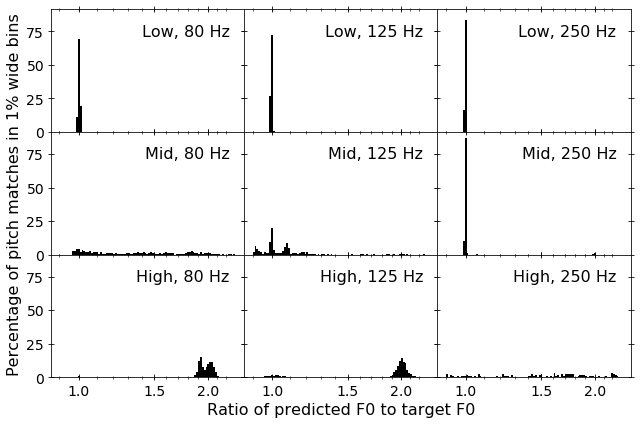

In [27]:
import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import f0experiment_alt_phase
importlib.reload(f0experiment_alt_phase)

json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_halfbandpass_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_highpass*_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0628/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0703/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
results_dict_list = []
for json_fn in json_fn_list:
    results_dict = f0experiment_alt_phase.run_f0experiment_alt_phase(json_fn)
    results_dict_list.append(results_dict)

    
def make_altphase_histograms(results_dict_input,
                             bin_step=0.01,
                             figsize=(9,6),
                             fontsize_labels=16,
                             fontsize_legend=16,
                             fontsize_ticks=14,
                             xticks=[1.0, 1.5, 2.0],
                             xlimits=[0.9, 2.3]):
    '''
    Function for plotting alternating phase experiment results:
    histograms of ratio between predicted F0s and target F0s
    for different F0 and filter conditions.
    '''
    if isinstance(results_dict_input, dict):
        results_dict_list = [results_dict_input]
    elif isinstance(results_dict_input, list):
        results_dict_list = results_dict_input
    else:
        raise ValueError("INVALID results_dict_input")
    # Pool data across subjects in results_dict_list
    rd0 = results_dict_list[0]
    filter_condition_list = rd0['f0_pred_ratio_results']['filter_condition_list']
    f0_condition_list = rd0['f0_pred_ratio_results']['f0_condition_list']
    kwargs_f0_pred_ratio = rd0['f0_pred_ratio_results']['kwargs_f0_pred_ratio']
    f0_pred_ratio_list = [[]] * len(filter_condition_list)
    for rd in results_dict_list:
        assert rd['f0_pred_ratio_results']['filter_condition_list'] == filter_condition_list
        assert rd['f0_pred_ratio_results']['f0_condition_list'] == f0_condition_list
        for idx, data in enumerate(rd['f0_pred_ratio_results']['f0_pred_ratio_list']):
            f0_pred_ratio_list[idx] = f0_pred_ratio_list[idx] + data
    
    filter_condition_to_label_map = {
        '125.0': 'Low',
        '1375.0': 'Mid',
        '3900.0': 'High',
    }
    
    NCOLS = len(np.unique(f0_condition_list))
    NROWS = len(np.unique(filter_condition_list))
    fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, sharex=True, sharey=True)
    ax_arr = ax_arr.flatten()
    xlabel_idx = NCOLS * NROWS - int(NCOLS/2) - 1
    ylabel_idx = NCOLS
    
    for itr0 in range(len(f0_pred_ratio_list)):
        ax = ax_arr[itr0]
        ax.set_xscale('log')
        label = '{}, {} Hz'.format(
            filter_condition_to_label_map[str(filter_condition_list[itr0])],
            f0_condition_list[itr0])
        
        # Create bins for the ratio histogram (log-scale)
        bins = [xlimits[0]]
        while bins[-1] < xlimits[1]: bins.append(bins[-1] * (1.0+bin_step))
        # Manually compute histogram and convert to percentage
        bin_counts, bin_edges = np.histogram(f0_pred_ratio_list[itr0], bins=bins)
        bin_percentages = 100.0 * bin_counts / np.sum(bin_counts)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_widths = bin_edges[:-1] - bin_edges[1:]
        ax.bar(bin_centers, bin_percentages, width=bin_widths, align='center', label=label, color='k')
        ax.legend(loc=0, frameon=False, markerscale=0, handlelength=0, fontsize=fontsize_legend)
        
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xticks(xticks)
        ax.set_xticks(np.arange(xlimits[0], xlimits[1], 0.1), minor=True)
        ax.tick_params(axis='y', which='both', labelsize=fontsize_ticks, length=6,
                       direction='inout', right=True, left=True)
        ax.tick_params(axis='x', which='major', labelsize=fontsize_ticks, length=6,
                       direction='inout', top=True, bottom=True)
        ax.tick_params(axis='x', which='minor', length=3,
                       direction='inout', top=True, bottom=True)
    
    ax_arr[xlabel_idx].set_xlabel('Ratio of predicted F0 to target F0',
                                  fontsize=fontsize_labels)
    ax_arr[ylabel_idx].set_ylabel('Percentage of pitch matches in {:.0f}% wide bins'.format(bin_step*100.0),
                                  fontsize=fontsize_labels)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, ax_arr

fig, ax_arr = make_altphase_histograms(results_dict_list)
plt.show()
# fig.savefig('figures/archive_2019_10_09_lab_meeting_figures/2019OCT07_AltPhase_RatioHistograms_arch_0628_PND_v04_TLAS.pdf', bbox_inches='tight')


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
%matplotlib inline
import matplotlib.pyplot as plt
import pdb
import f0experiment_alt_phase


json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS*_classification*/EVAL_AltPhase_v01_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_[ch]*lassification*/EVAL_AltPhase_v01_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0628/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0703/PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt.json'

json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name.replace('_bestckpt.json', '')
    model_name = model_name[:model_name.rfind('/')] + '\n' + model_name[model_name.rfind('/'):]
    model_name_list.append(model_name)

results_dict_list = []
for json_fn, model_name in zip(json_fn_list, model_name_list):
    print(json_fn)
    fn_results_dict = json_fn.replace('.json', '_results_dict.json')
    if os.path.exists(fn_results_dict):
        print('loading pre-computed file')
        with open(fn_results_dict) as f:
            results_dict = json.load(f)
    else:
        results_dict = f0experiment_alt_phase.main(json_fn, phase_mode=4, f0_min=None, f0_max=None, f0_nbins=12,
                                                   f0_label_pred_key = 'f0_label:labels_pred',
                                                   f0_label_true_key = 'f0_label:labels_true')
    results_dict_list.append(results_dict)

    

NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.5*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
    ax = ax_arr[idx]
    
    for key in sorted(results_dict['filter_fl_bin_means'].keys()):
        ax.plot(results_dict['f0_bin_centers'], results_dict['filter_fl_bin_means'][key], 'o-', label=key)
    
    ax.legend(loc=0, frameon=False, handlelength=2, markerscale=0, fontsize=8)
    ax.set_xscale('log')
    ax.set_title(model_name)
    

for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import f0experiment_mistuned_harmonics


json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS*_classification*/EVAL_MistunedHarm_v00_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_RSB/PND_v04_JWSS*_classification*/EVAL_MistunedHarm_v00_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_[ch]*lassification*/EVAL_MistunedHarm_v00_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification*/EVAL_MistunedHarm_v00_bestckpt.json'
json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0628/PND_v04_TLAS_classification*/EVAL_MistunedHarm_v00_bestckpt.json'
# json_regex = '/om2/user/msaddler/pitchnet/saved_models/arch_0703/PND_v04_TLAS_classification*/EVAL_MistunedHarm_v00_bestckpt.json'


json_fn_list = sorted(glob.glob(json_regex))
model_name_list = []
for json_fn in json_fn_list:
    model_name = json_fn.replace('/om2/user/msaddler/pitchnet/saved_models/', '')
    model_name = model_name.replace('_bestckpt.json', '')
    model_name = model_name[:model_name.rfind('/')] + '\n' + model_name[model_name.rfind('/'):]
    model_name_list.append(model_name)

results_dict_list = []
for json_fn, model_name in zip(json_fn_list, model_name_list):
    print(json_fn)
    fn_results_dict = json_fn.replace('.json', '_results_dict.json')
    if os.path.exists(fn_results_dict):
        print('loading pre-computed file')
        with open(fn_results_dict) as f:
            results_dict = json.load(f)
    else:
        if 'regress' in json_fn:
            f0_label_pred_key = 'f0_lognormal:labels_pred'
            f0_label_true_key = 'f0_lognormal:labels_true'
        else:
            f0_label_pred_key = 'f0_label:labels_pred'
            f0_label_true_key = 'f0_label:labels_true'

        results_dict = f0experiment_mistuned_harmonics.run_f0experiment_mistuned_harmonics(json_fn)
    results_dict_list.append(results_dict)

for f0_ref in [200.0]:#[100.0, 200.0, 400.0]:
    f0_ref_key = str(f0_ref)
    print('f0_ref = {}'.format(f0_ref_key))
    NCOLS = 3
    NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
    fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(5*NCOLS, 3*NROWS))
    ax_arr = ax_arr.flatten()

    for idx, (results_dict, model_name) in enumerate(zip(results_dict_list, model_name_list)):
        ax = ax_arr[idx]

        sub_results_dict = results_dict['f0_ref'][f0_ref_key]

        for key in sorted(sub_results_dict['mistuned_harm'].keys()):
            xval = sub_results_dict['mistuned_harm'][key]['mistuned_pct']
            yval = sub_results_dict['mistuned_harm'][key]['f0_pred_pct_median']#['f0_pred_pct_mean']
            yerr = sub_results_dict['mistuned_harm'][key]['f0_pred_pct_stddev']
            ax.plot(xval, yval, '.-', label=key, markersize=8)

        ax.legend(loc=4, frameon=False, ncol=2, handlelength=2, markerscale=0, fontsize=8)
        ax.set_title(model_name)
        ax.set_xlabel('Shift in harmonic (%)')
        ax.set_ylabel('Shift in predicted F0 (%)')
    #     ax.set_xlim([-0.5, 24.5])
    #     ax.set_ylim([-1.0, 0.25])


    for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # fig.savefig('figures/archive_2019_08_28_archSearch00_RSBpsychophysics/2019AUG27_RSB_PNDv04_moore1985_MistunedHarm_f0near100Hz_median.pdf', bbox_inches='tight')
